In [115]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Overfitting and regularisation in classification

We have previously encountered the [non-linear generalisation of linear classification methods](classification_non-linear.ipynb). These new non-linear models are more powerful, but they can now over-fit to the training data. In this section we will look at a couple of instances of this phenomenum using test-train splits to diagnose the problem.

### Example 1: Overfitting in linear binary logistic classification

Although over-fitting is most problematic for non-linear models, it can still occur in linear models. The 2D Iris dataset we have used before is shown below with the data split into 75% for training and 25% for testing.

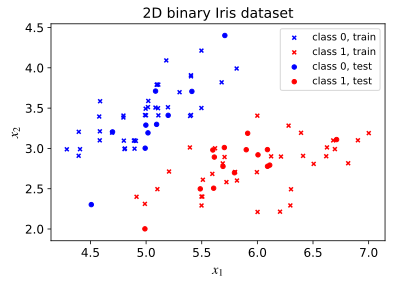

In [116]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2

x = x[:,0:2] 

ax = plt.subplot(1,1,1)
no_test = (x.shape[0]*1)//4
x_test, x_train, y_test, y_train = x[:no_test], x[no_test:], y[:no_test], y[no_test:]

class_0_train, class_1_train = np.where(y_train == 0), np.where(y_train == 1)
plt.scatter(x_train[class_0_train, 0], x_train[class_0_train, 1], color = 'blue', marker = 'x', s = 15,label='class 0, train')
plt.scatter(x_train[class_1_train, 0], x_train[class_1_train, 1], color = 'red', marker = 'x', s = 15,label='class 1, train')

class_0_test, class_1_test = np.where(y_test == 0), np.where(y_test == 1)


plt.scatter(x_test[class_0_test, 0], x_test[class_0_test, 1], color = 'blue', marker = 'o', s = 20,label='class 0, test')
plt.scatter(x_test[class_1_test, 0], x_test[class_1_test, 1], color = 'red', marker = 'o', s =20,label='class 1, test')
ax.legend()
beautify_plot({"title":r"2D binary Iris dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()


toggle_code(title = "2D Iris Dataset", on_load_hide = True)

We will now run the code that fits the model using maximum-likelihood estimation through gradient ascent. Before running the code, take a moment to consider the following questions:

1. **Where will the decision boundary lie after running many iterations?** 
2. **What will the magnitude of the weights be?**
3. **What will be the held out log-likelihood of the resulting model** i.e. $\prod_{n=1}^{N_{\text{test}}} p(y_n^{\ast} | \mathbf{w},x_n^{\ast})$?

If the answer to this questions is not obvious, you may like to experiment with the code to allow, varying the number of iterations to get a picture about what's happening. 

In [86]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, x_test, y_test, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    x_test = np.append(np.ones(shape = (x_test.shape[0], 1)), x_test, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks, log_liks_test = [],[],[] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        log_liks_test.append(np.sum(y_test * np.log(sig(x_test.dot(w))) + (1 - y_test) * np.log(1 - sig(x_test.dot(w))))) # record current log-lik

        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks), np.array(log_liks_test)

HTML(toggle_code("gradient ascent function"))

<IPython.core.display.HTML object>

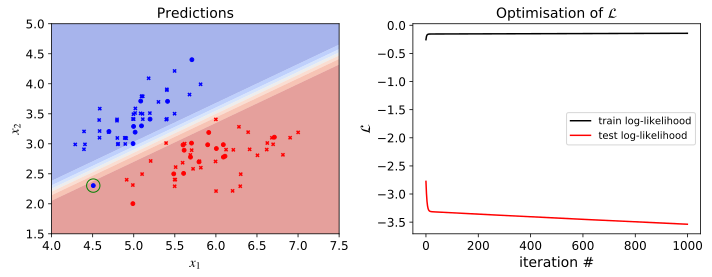

Final training log-likelihood = -0.98 nats
Final test log-likelihood = -3.54 nats


<IPython.core.display.HTML object>

In [114]:
w_init = [-4,7,-11]  # use a good initialisation to speed up simulation: 
                      # there is a unique optimum, so poorer initialisations will just entail waiting for longer

w_history, log_liks_train, log_liks_test = gradient_ascent(x_train, y_train, x_test, y_test, w_init, 1000, 0.5)

x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(1.5, 5, 100)

test_grid = np.stack(np.meshgrid(x1, x2), axis = 2).reshape((-1, 2))

test_grid = np.append(np.ones(shape = (test_grid.shape[0], 1)), test_grid, axis = 1)

pred = sig(test_grid.dot(w_history[-1])).reshape(100, 100)


fig=plt.figure(figsize=(10, 4), dpi= 80)


plt.subplot(1,2,1)
plt.contourf(x1, x2,pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0_train, 0], x_train[class_0_train, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1_train, 0], x_train[class_1_train, 1], color = 'red', marker = 'x', s = 10)

plt.scatter(x_test[class_0, 0], x_test[class_0, 1], color = 'blue', marker = 'o', s = 15)
plt.scatter(x_test[class_1, 0], x_test[class_1, 1], color = 'red', marker = 'o', s = 15)
beautify_plot({"title":r"Predictions", "x":"$x_1$", "y":"$x_2$"})
plt.scatter([4.50747563], [2.30301912], color = 'green', marker = 'o', s = 180,facecolors='none')


ax2 = plt.subplot(1,2,2)
plt.plot(log_liks, color = 'black',label='train log-likelihood')
plt.plot(log_liks_test, color = 'red',label='test log-likelihood')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"iteration #", "y":"$\mathcal{L}$"})
ax2.legend()

fig.tight_layout()
plt.show()

x = np.arange(10)

print("Final training log-likelihood = {0:.2f} nats".format(log_liks_train[-1]))
print("Final test log-likelihood = {0:.2f} nats".format(log_liks_test[-1]))

HTML(toggle_code())

The training data above are linearly separable. For this reason there are a set of maximum-likelihood solutions. Each solution places the linear decision boundary so that it divides the two classes (there are many ways to do this) and then makes the logistic function as steep as possible - i.e. a step function - so that the probability of each datapoint goes to 1 and the training log-likelihood goes to zero. Numerical problems may be encountered before this limit is reached as this behaviour causes the magnitude of the weights to go to infinity. 

Whilst the training likelihood of the maximum-likelihood solution is one, the test likelihood is zero. The blue test point in the bottom left (indicated by a green circle) is classified as being in class 1 which is incorrect. Worse still, it makes this prediction with probability 1 as the point is below the hard decision boundary, which zeros the likelihood. 

Clearly this is an instance of overfitting as the training likelihood is as high as it can possibly be and the test log-likelihood is as low as it can possibly be. The model is overconfident. Notice that this behaviour is very likely to happen for small numbers of datapoints which will often be linearly separable by chance. 

### Example 2: Overfitting in non-linear binary logistic classification

Let's consider a second example.

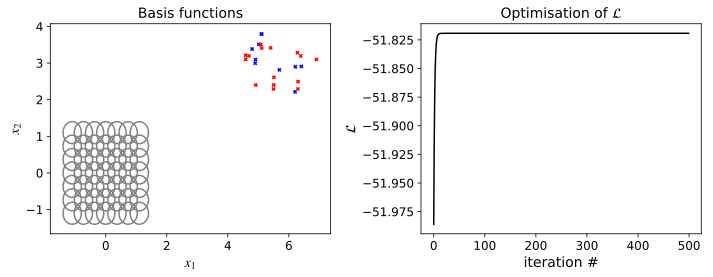

Final log-likelihood = -51.82 nats


<IPython.core.display.HTML object>

In [67]:
#x = np.load('class_1d_inputs.npy')
#y = np.load('class_1d_labels.npy')
#x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')

x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]

lengthscale = 0.3
no_x

mu1 = np.linspace(-1.1, 1.1, no_x)

phi = np.exp(-np.sum((mu1 - x_train)**2, axis = -1)/(2*lengthscale**2)).reshape((x_train.shape[0], -1))

w_history, log_liks = gradient_ascent(phi, y_train, np.zeros(shape = (no_x*no_y + 1,)), 500, 1)


fig=plt.figure(figsize=(10, 4), dpi= 80)


plt.subplot(1,2,1)

theta = np.linspace(0,2*np.pi,50)                  
x_circ = lengthscale*np.cos(theta)    
y_circ = lengthscale*np.sin(theta)                        
                    
for a in range(no_x):
    for b in range(no_y):
        xs = mu1[a] + x_circ
        ys = mu2[b] + y_circ
        plt.plot(xs,ys,color = 'gray')
                    
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)



beautify_plot({"title":r"Basis functions", "x":"$x_1$", "y":"$x_2$"})


plt.subplot(1,2,2)
plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"iteration #", "y":"$\mathcal{L}$"})


fig.tight_layout()
plt.show()

x = np.arange(10)

print("Final log-likelihood = {0:.2f} nats".format(log_liks[-1]))
HTML(toggle_code())


------


plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(log_liks, color = 'black') # plot log likelihoods
beautify_plot({"title":r"Evolution of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})

plt.subplot(1, 2, 2)

x_1, x_2 = x_train[np.where(y_train == 0)[0]], x_train[np.where(y_train == 1)[0]]

xs = np.linspace(-2.2, 4.2, 100)

plt.plot(xs, sig(xs * w_history[0, 1] + w_history[0, 0]), color = 'blue', zorder = 3, label = 'Before')
plt.plot(xs, sig(xs * w_history[-1, 1] + w_history[-1, 0]), color = 'red', zorder = 3, label = 'After')

plt.scatter(x_1, np.zeros_like(x_1), color = 'white', edgecolor = 'black', marker = 'o', s = 30,
            zorder = 2, label = '$y = 0$')
plt.scatter(x_2, np.zeros_like(x_2), color = 'black', marker = 'x', s = 40, zorder = 1, label = '$y = 1$')

beautify_plot({"title":r"Data space", "x":"$x$", "y":"$p(y = 1|\mathbf{w}, x)$"})
plt.gca().legend()
plt.tight_layout()
plt.show()



Now lets try and visualise the predictions of the trained model as probability contours in the input space $\mathbf{x}$. In the  figure below input points that have a strong red colour correspond to confident predictions of class 1, points that are  a strong blue colour correspond to confident predictions of class 0, and points that are not strongly coloured are close to 50:50. The probability contours are clearly non-linear and the model appears to be making reasonable predictions.

In [ ]:
test_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100)), axis = 2).reshape((-1, 2))
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*test_grid.shape[0], axis = 0)

points = np.stack([test_grid]*no_x*no_y, axis = 1).reshape((test_grid.shape[0], no_x, no_y, 2))
phi_ = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((test_grid.shape[0], -1))
phi_pred = np.append(np.ones(shape = (phi_.shape[0], 1)), phi_, axis = -1)


pred = sig(phi_pred.dot(w_history[-1])).reshape(100, 100)
plt.contourf(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100),
             pred, cmap = 'coolwarm', alpha = 0.5, origin = 'lower')
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color = 'blue', marker = 'x', s = 10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color = 'red', marker = 'x', s = 10)
beautify_plot({"title":r"Crescent dataset descision boundaries", "x":"$x_1$", "y":"$x_2$"})
plt.show()

(HTML(toggle_code()))

Finally, lets see how the model performs on the test set.

In [ ]:
def test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = sig(x_.dot(w))
    return 1 - abs((y_.round() - test_y)).mean()

rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, no_x), np.linspace(-1.1, 1.1, no_y)), axis = 2)
rbf_grid = np.stack([rbf_grid]*x_test.shape[0], axis = 0)

points = np.stack([x_test]*no_x*no_y, axis = 1).reshape((x_test.shape[0], no_x, no_y, 2))
phi = np.exp(-np.sum((rbf_grid - points)**2, axis = -1)/(2*lengthscale**2)).reshape((x_test.shape[0], -1))

print("Classification accuracy for non-linear dataset = {}%".format(test_accuracy(phi, y_test, w_history[-1])*100))

HTML(toggle_code())

### Summary

Logistic and softmax classification can be turned into non-linear classifiers simply by changing the representation of the input. Instead of passing the inputs $\mathbf{x}_n$ directly to the algorithm, we can pass non-linear functions of the input $\boldsymbol{\Phi}(\mathbf{x}_n)$. These functions are called basis functions or features.

The basis functions need careful design (e.g. see question 1 below). Moreover, the naive method of tiling the space, as used in the examples above, does not scale to high dimensional input spaces where an exponential number of functions would be required. However, strategies such as centering radial basis functions at a randomly selected subset of the datapoints can sidestep the curse of dimensionality and work reasonably well.


In [section 3.5](classification_bayesian.ipynb) we will look at a Bayesian approach to logistic regression.

### Questions

**1. Effect of the number and length-scale of the basis functions**

Experiment with the code above to investigate the effect of using large and short length-scales in the basis functions, and small or large numbers of basis functions. See how these choices alter the final log-likelihood and the predictive probability contours.

<details>
<summary>Answer</summary>
<div>
    
Using very narrow radial basis functions with short length-scales results in probability contours that are less smooth and requires more basis functions for sensible predictions. Using broader radial basis function results in smoother contours and fewer basis functions are required, but the predictions might be overly simplistic.<br><br>

One useful rule of thumb for setting the width of radial basis functions is called the **median trick**. The median trick begins by computing the pairwise distances between the datapoints' inputs. It then sets the length-scale to be the median distance value.

</div>
</details>

**2. Overfitting**

Can you make the model above overfit? Change the length-scale and number of the basis functions, and increase the number of iterations of gradient ascent.

<details>
<summary>Answer</summary>
<div>
When large numbers of narrow basis functions are used (e.g. D = 40 x 40, l = 0.02) and many iterations of gradient ascent applied (e.g. tens of thousands) the model starts to overfit. Such a simulation can take a long time to run, but the log-likelihood asymptotes close to 0, whilst the test set accuracy is around 90% which is less than it was for the original setting (D = 7 x 7, l = 0.3, 500 iterations scores 100% accuracy on the test set). <br><br>

This is a classic example of overfitting: the model complexity grows with the number of basis functions and as the length-scale gets shorter. At somepoint the model can perfectly capture the training data, but makes poor predictions on the test data. One approach to preventing overfitting is to regularise the weights. Another, arguably less principled, approach is to use early stopping: that is, terminate gradient ascent before the model starts to overfit. 


</div>
</details>
